<a href="https://colab.research.google.com/github/hannamakarova/E-Commerce_Sales_Analysis/blob/main/P2_E_Commerce_Sales_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **E-Commerce Sales Analysis: Insights into User Behavior, Traffic Dynamics, and Regional Performance**

This project aims to analyze sales data from an e-commerce platform to uncover valuable insights into user behavior, regional performance, product preferences, and marketing effectiveness.

The dataset includes information about customer sessions, product categories, sales performance, user subscriptions, and traffic channels. Key analyses focus on identifying high-performing regions, understanding customer preferences, and evaluating the impact of different marketing channels and devices on overall revenue.

Tools and Techniques:

* Data Analysis: SQL queries and Python for data preprocessing and analysis.
* Visualization: Seaborn and Matplotlib for creating insightful visualizations.
* Statistical Testing: Pearson and Spearman correlation, Shapiro-Wilk test, and Mann-Whitney U test for understanding data relationships.

Tableau: https://public.tableau.com/app/profile/hanna.makarova5369/viz/Project2_17374953677060/Story1?publish=yes

In [ ]:
!pip install --upgrade google-cloud-bigquery

from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Authentication
auth.authenticate_user()

# Creating a client for BigQuery
client = bigquery.Client(project="data-analytics-mate")

# SQL query
query = """
WITH
  session_info AS (
    SELECT
      s.date,
      o.ga_session_id,
      o.item_id,
      sp.continent,
      sp.country,
      sp.device,
      sp.browser,
      sp.mobile_model_name,
      sp.operating_system,
      sp.language,
      sp.channel,
      p.category,
      p.name,
      p.price,
      p.short_description
    FROM
      `data-analytics-mate.DA.order` o
    JOIN
      `DA.session` s
    ON
      o.ga_session_id = s.ga_session_id
    JOIN
      `DA.session_params` sp
    ON
      sp.ga_session_id = o.ga_session_id
    JOIN
      `DA.product` p
    ON
      p.item_id = o.item_id
  ),
  account_info AS (
    SELECT
      acs.ga_session_id,
      a.id AS account_id,
      CASE
        WHEN a.is_verified = 0 THEN 'not verified'
        ELSE 'verified'
      END AS verification,
      CASE
        WHEN a.is_unsubscribed = 0 THEN 'subscribed'
        ELSE 'unsubscribed'
      END AS subscription
    FROM
      `DA.account_session` acs
    JOIN
      `DA.account` a
    ON
      acs.account_id = a.id
  )
SELECT
  session_info.date,
  session_info.ga_session_id,
  session_info.item_id,
  session_info.continent,
  session_info.country,
  session_info.device,
  session_info.browser,
  session_info.mobile_model_name,
  session_info.operating_system,
  session_info.language,
  session_info.channel,
  account_info.account_id,
  account_info.verification,
  account_info.subscription,
  session_info.category,
  session_info.name,
  session_info.price,
  session_info.short_description
FROM
  session_info
left join account_info
on session_info.ga_session_id = account_info.ga_session_id

"""
# Executing the query
query_job = client.query(query)  # Execute the SQL query
results = query_job.result()  # Wait for the query to complete

# Converting the results to a DataFrame
df = results.to_dataframe()

# Displaying the result
df.head()

# Optionally, save the DataFrame to a CSV file
# df.to_csv('project2_data.csv', index=False)

# Optionally, download the CSV file
# from google.colab import files
# files.download('project2_data.csv')

,date,ga_session_id,item_id,continent,country,device,browser,mobile_model_name,operating_system,language,channel,account_id,verification,subscription,category,name,price,short_description
0,2020-12-24,5726438444,89279174,(not set),(not set),desktop,Chrome,Chrome,Web,None,Paid Search,<NA>,None,None,Cabinets & cupboards,LIXHULT,356.0,"Wall-mounted cabinet combination, 50x25x50 cm"
1,2020-12-13,5614986004,69282629,(not set),(not set),desktop,<Other>,<Other>,Web,en-ca,Organic Search,<NA>,None,None,Tables & desks,BEKANT,1325.0,"Desk, 140x60 cm"
2,2020-11-05,8542454082,80426928,(not set),(not set),desktop,Chrome,Safari,Web,en-us,Undefined,<NA>,None,None,Chairs,ANTILOP,20.0,Cover
3,2020-12-16,1717992506,39041660,(not set),(not set),mobile,Safari,iPhone,Web,en-us,Undefined,<NA>,None,None,Beds,SUNDVIK,849.0,"Ext bed frame with slatted bed base, 80x200 cm"
4,2021-01-16,8416141289,69903836,(not set),(not set),desktop,Chrome,Safari,Web,en-gb,Direct,<NA>,None,None,Bookcases & shelving units,ALGOT,130.0,"Wall upright/drying rack, 66x41x197 cm"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33538 entries, 0 to 33537
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               33538 non-null  dbdate 
 1   ga_session_id      33538 non-null  Int64  
 2   item_id            33538 non-null  Int64  
 3   continent          33538 non-null  object 
 4   country            33538 non-null  object 
 5   device             33538 non-null  object 
 6   browser            33538 non-null  object 
 7   mobile_model_name  33538 non-null  object 
 8   operating_system   33538 non-null  object 
 9   language           22531 non-null  object 
 10  channel            33538 non-null  object 
 11  account_id         2781 non-null   Int64  
 12  verification       2781 non-null   object 
 13  subscription       2781 non-null   object 
 14  category           33538 non-null  object 
 15  name               33538 non-null  object 
 16  price              335

In [ ]:
# 1. Total number of columns
total_columns = df.shape[1]

# 2. Number of numeric columns and their names
numeric_columns = df.select_dtypes(include=['number']).columns

# 3. Number of categorical columns and their names
categorical_columns = df.select_dtypes(include=['object']).columns

# 4. Number of datetime columns and their names
datetime_columns = df.select_dtypes(include=['datetime']).columns

print(f"Total number of columns: {total_columns}")
print(f"Number of numeric columns: {len(numeric_columns)}, Names: {numeric_columns.tolist()}")
print(f"Number of categorical columns: {len(categorical_columns)}, Names: {categorical_columns.tolist()}")
print(f"Number of datetime columns: {len(datetime_columns)}, Names: {datetime_columns.tolist()}")


Total number of columns: 18
Number of numeric columns: 4, Names: ['ga_session_id', 'item_id', 'account_id', 'price']
Number of categorical columns: 13, Names: ['continent', 'country', 'device', 'browser', 'mobile_model_name', 'operating_system', 'language', 'channel', 'verification', 'subscription', 'category', 'name', 'short_description']
Number of datetime columns: 0, Names: []


In [ ]:
# 5. Number of unique sessions
session_count = df['ga_session_id'].nunique()
print(f"Number of unique sessions: {session_count}")

# 6. Time period
max_date = df['date'].max()
min_date = df['date'].min()
period = max_date - min_date
print(f"From {min_date} to {max_date}. Total duration: {period}")

Number of unique sessions: 33538
From 2021-01-27 to 2020-11-01. Total 87 days, 0:00:00


In [ ]:
# 7. Checking for missing values
df.isnull().sum()


,0
date,0
ga_session_id,0
item_id,0
continent,0
country,0
device,0
browser,0
mobile_model_name,0
operating_system,0
language,11007


In [ ]:
# 9. Percentage of missing values per column
missing_reason = df.isnull().mean() * 100

print(missing_reason)

date                  0.000000
ga_session_id         0.000000
item_id               0.000000
continent             0.000000
country               0.000000
device                0.000000
browser               0.000000
mobile_model_name     0.000000
operating_system      0.000000
language             32.819488
channel               0.000000
account_id           91.707913
verification         91.707913
subscription         91.707913
category              0.000000
name                  0.000000
price                 0.000000
short_description     0.000000
dtype: float64



Based on the data you provided, the following columns have missing values:

* language: 11,007 missing values
* account_id: 30,757 missing values
* verification: 30,757 missing values
* subscription: 30,757 missing values

Missing values in the columns account_id, verification, and subscription may be due to these fields not being recorded for certain sessions or being unavailable for specific users. Further analysis is needed to determine the underlying reasons for these missing values.

### Series of business analysis questions related to e-commerce data.

In [ ]:
# 1. Top 3 continents by total sales and number of orders
top_continent_sales = df.groupby('continent')['price'].sum().sort_values(ascending=False).head(3).reset_index()
top_continent_sales.rename(columns={'price':'sales'}, inplace=True)
print(top_continent_sales)
top_continent_orders = df.groupby('continent')['ga_session_id'].nunique().sort_values(ascending=False).head(3).reset_index()
top_continent_orders.rename(columns={'ga_session_id':'sessions'}, inplace=True)
print(top_continent_orders)

  continent       sales
0  Americas  17665280.0
1      Asia   7601298.3
2    Europe   5934624.2
  continent  sessions
0  Americas     18553
1      Asia      7950
2    Europe      6261


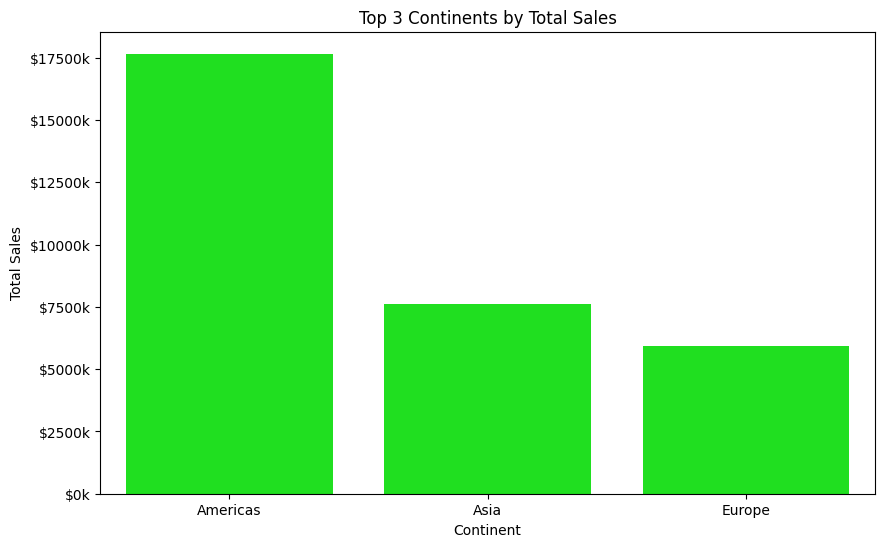

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data =top_continent_sales, x="continent", y="sales", color='lime')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${int(y/1000)}k'))
plt.title('Top 3 Continents by Total Sales')
plt.ylabel('Total Sales')
plt.xlabel('Continent')
plt.show()


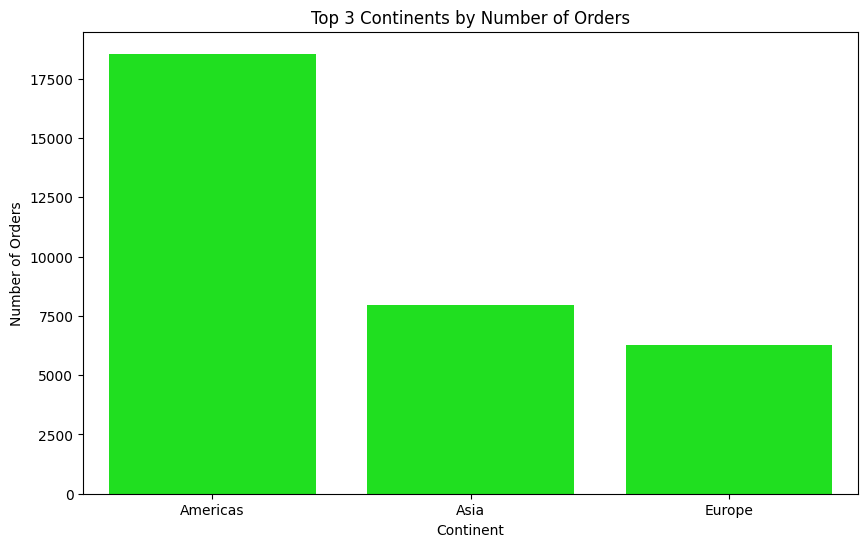

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data =top_continent_orders, x="continent", y="sessions", color='lime')
plt.title('Top 3 Continents by Number of Orders')
plt.ylabel('Number of Orders')
plt.xlabel('Continent')
plt.show()

In [ ]:
top_countries_sales = df.groupby('country')['price'].sum().sort_values(ascending=False).head(5).reset_index()
top_countries_sales.rename(columns={'price':'sales'}, inplace=True)
print(top_countries_sales)

top_countries_orders = df.groupby('country')['ga_session_id'].nunique().sort_values(ascending=False).head(5).reset_index()
top_countries_orders.rename(columns={'ga_session_id':'sessions'}, inplace=True)
print(top_countries_orders)


          country       sales
0   United States  13943553.9
1           India   2809762.0
2          Canada   2437921.0
3  United Kingdom    938317.9
4          France    710692.8
          country  sessions
0   United States     14673
1           India      3029
2          Canada      2560
3  United Kingdom      1029
4          France       678


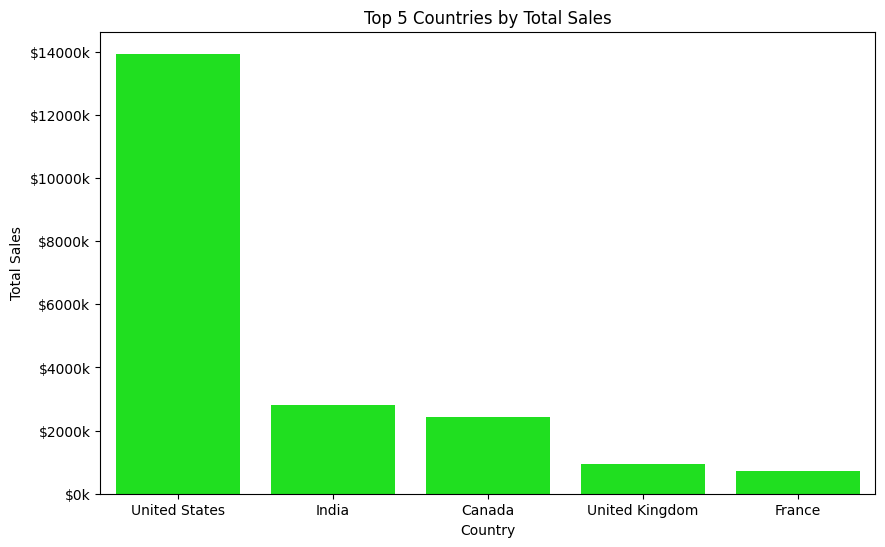

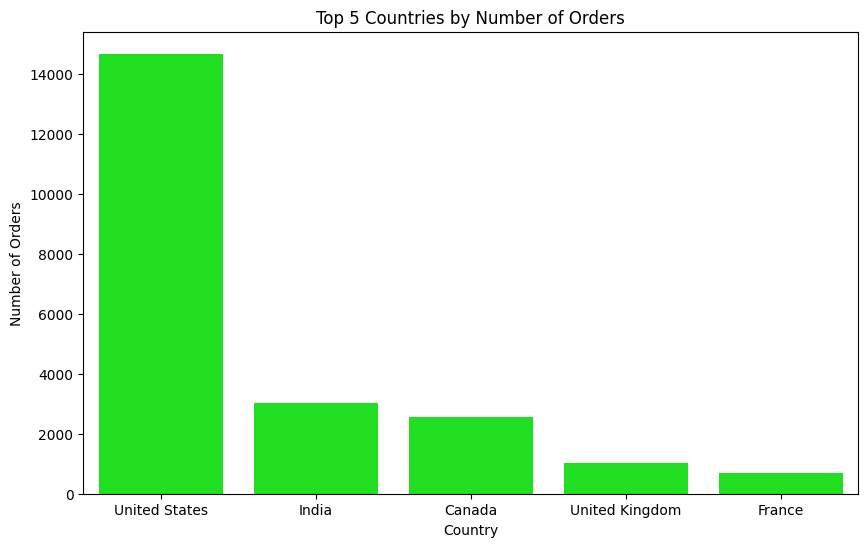

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data =top_countries_sales, x="country", y="sales", color='lime')
plt.title('Top 5 Countries by Total Sales')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${int(y/1000)}k'))
plt.ylabel('Total Sales')
plt.xlabel('Country')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data =top_countries_orders, x="country", y="sessions", color='lime')
plt.title('Top 5 Countries by Number of Orders')
plt.ylabel('Number of Orders')
plt.xlabel('Country')
plt.show()

In [ ]:
# 3. Top 10 product categories by total sales
top_categories_sales = df.groupby('category')['price'].sum().sort_values(ascending=False).head(10).reset_index()
top_categories_sales.rename(columns={'price':'sales'}, inplace=True)
print(top_categories_sales)

                           category      sales
0                 Sofas & armchairs  8388254.5
1                            Chairs  6147748.8
2                              Beds  4919725.0
3        Bookcases & shelving units  3640818.1
4              Cabinets & cupboards  2336499.5
5                 Outdoor furniture  2142222.2
6                    Tables & desks  1790307.5
7  Chests of drawers & drawer units   906562.5
8                     Bar furniture   735503.0
9              Children's furniture   467697.0


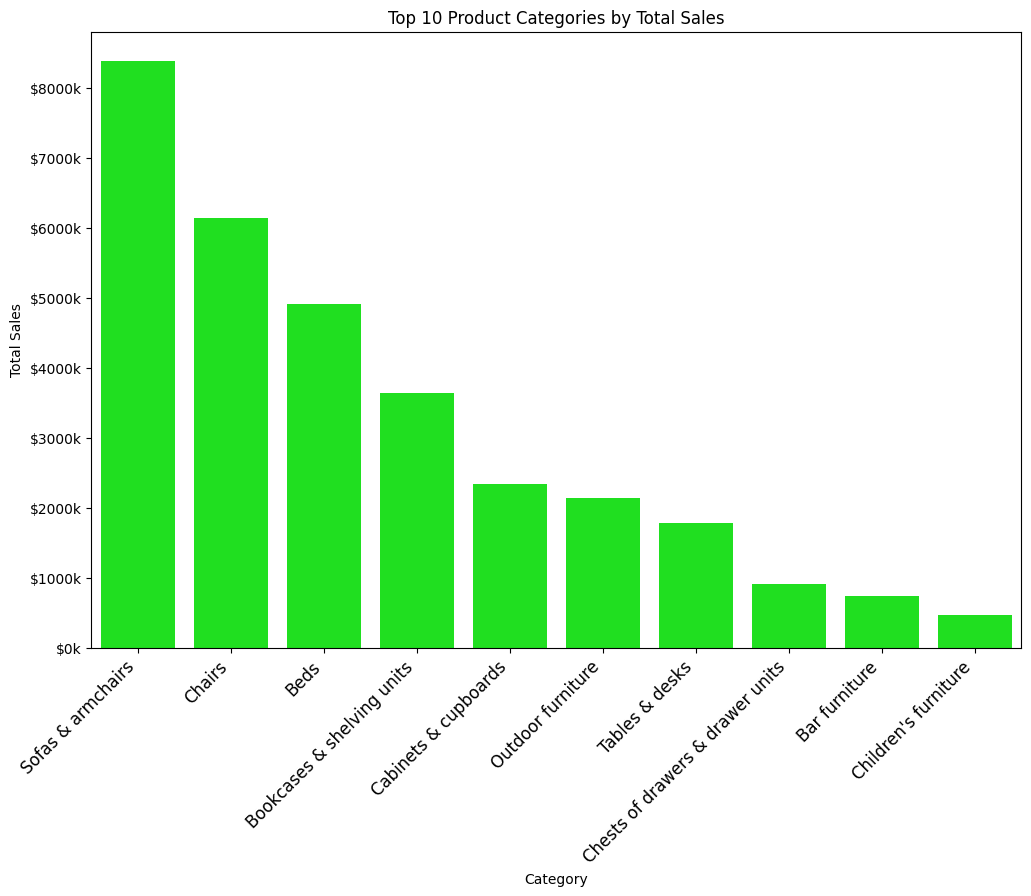

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(data =top_categories_sales, x="category", y="sales", color='lime')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${int(y/1000)}k'))
plt.title('Top 10 Product Categories by Total Sales')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.xlabel('Category')
plt.show()

In [ ]:
# 4. Top 10 product categories in the country with the highest sales

top_country_sales_data = df.groupby('country')['price'].sum().sort_values(ascending=False).head(10)
top_country = top_country_sales_data.idxmax()

top_country_sales = df[df['country'] == top_country].groupby('category')['price'].sum().sort_values(ascending=False).head(10).reset_index()
top_country_sales.rename(columns={'price':'sales'}, inplace=True)
print(top_country_sales)

                           category      sales
0                 Sofas & armchairs  3707144.5
1                            Chairs  2619773.8
2                              Beds  2213058.0
3        Bookcases & shelving units  1567606.9
4              Cabinets & cupboards   994545.5
5                 Outdoor furniture   929245.2
6                    Tables & desks   777865.0
7  Chests of drawers & drawer units   382388.0
8                     Bar furniture   330805.0
9              Children's furniture   207575.0


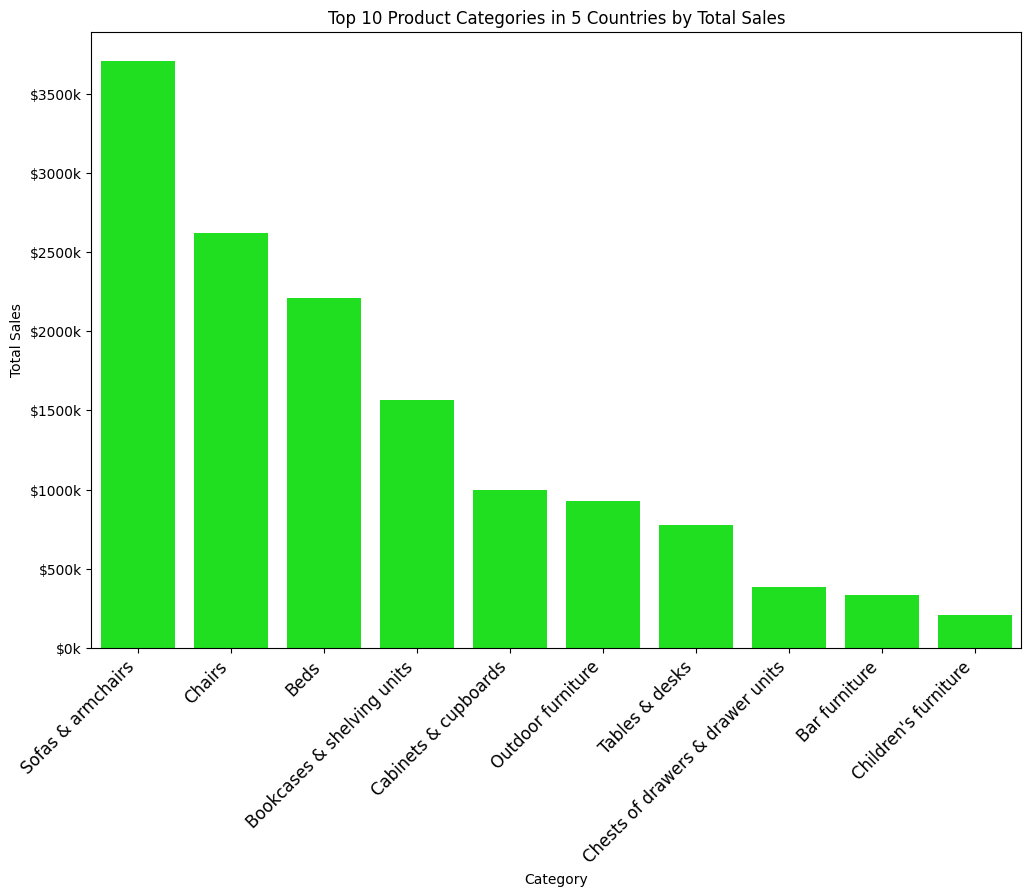

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(data =top_country_sales, x="category", y="sales", color='lime')
plt.title(f'Top 10 Product Categories in 5 Countries by Total Sales')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${int(y/1000)}k'))
plt.ylabel('Total Sales')
plt.xlabel('Category')
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.show()

In [ ]:
# 5. Sales by device type and model (as a % of total sales)
device_sales = df.groupby('device')['price'].sum() / df['price'].sum() * 100
print(device_sales)

device
desktop    59.002245
mobile     38.734924
tablet      2.262831
Name: price, dtype: float64


In [ ]:
# 6. Sales by traffic source (as a % of total sales)
channel_sales_percent = df.groupby('channel')['price'].sum() / df['price'].sum() * 100
print(channel_sales_percent)

channel
Direct            23.442345
Organic Search    35.760189
Paid Search       26.620546
Social Search      7.919827
Undefined          6.257093
Name: price, dtype: float64


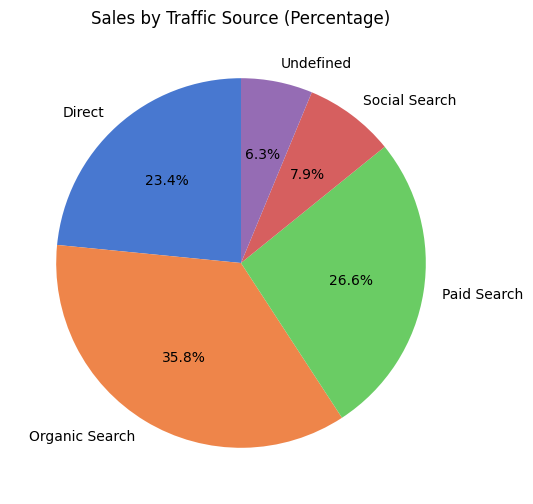

In [ ]:
plt.figure(figsize=(10, 6))
channel_sales_percent.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette('muted'))
plt.title('Sales by Traffic Source (Percentage)')
plt.ylabel('')
plt.show()


In [ ]:
# 7. Percentage of users who confirmed their email address (verification)
verified_users_percentage = df['verification'].notnull().sum()/df['verification'].isnull().sum()*100
print(f"Percentage people who was verified: {verified_users_percentage}")

Percentage people who was verified: 9.041844133042884


In [ ]:
#8. Percentage of users who unsubscribed from the newsletter
unsubscribed_rate = (df['subscription'] == 'unsubscribed').sum() / (df['subscription'] != 'unsubscribed').sum() *100
print(f"Percentage people who unsubscribed: {unsubscribed_rate}")


Percentage people who unsubscribed: 1.350820464778943


In [ ]:
# 9. Comparison of sales between users who unsubscribed from the newsletter and those who are subscribed
subscribed_sales = df[(df['subscription'] == 'subscribed')]['price'].sum()
unsubscribed_sales = df[(df['subscription'] == 'unsubscribed')]['price'].sum()
subscribed_sales_percentage = subscribed_sales / (subscribed_sales + unsubscribed_sales) * 100
unsubscribed_sales_percentage = unsubscribed_sales / (subscribed_sales + unsubscribed_sales) * 100

print(f"Sales who subscribed {subscribed_sales_percentage}")
print(f"Sales who unsubscribed {unsubscribed_sales_percentage}")

Sales who subscribed 83.28292323946566
Sales who unsubscribed 16.717076760534336


In [ ]:
# 10. Countries with the most registered users
top_registered_countries = df.groupby('country')['ga_session_id'].nunique().sort_values(ascending=False).head(5).reset_index()
top_registered_countries.rename(columns={'ga_session_id':'sessions'}, inplace=True)
print(top_registered_countries)

          country  sessions
0   United States     14673
1           India      3029
2          Canada      2560
3  United Kingdom      1029
4          France       678


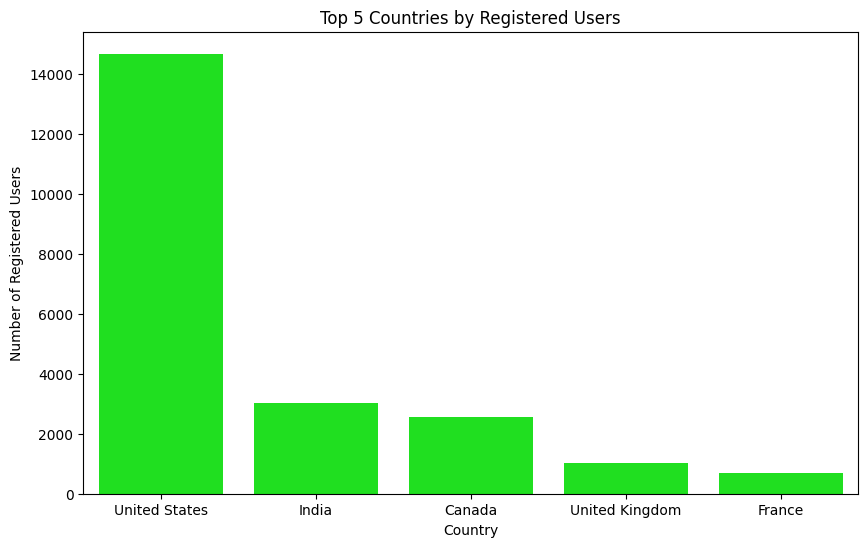

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data =top_registered_countries, x="country", y="sessions",color='lime')
plt.title('Top 5 Countries by Registered Users')
plt.ylabel('Number of Registered Users')
plt.xlabel('Country')
plt.show()

1. Top Continents by Sales and Orders
Conclusion: The Americas lead in total sales and the number of sessions, contributing significantly to the overall revenue. Asia and Europe follow, indicating these regions are key markets.
2. Top Countries by Sales and Orders
Conclusion: The United States dominates both sales and sessions, showcasing its pivotal role in the market. India and Canada are also prominent, while European countries like the UK and France contribute less.
3. Top Product Categories by Sales
Conclusion: Sofas and armchairs are the highest-grossing category, followed by chairs and beds, highlighting a preference for home furniture. Other categories like bookcases and cabinets also show strong sales.
4. Top Categories in the Highest-Selling Country
Conclusion: In the United States, the product preference mirrors the global trend with sofas, chairs, and beds being the most popular.
5. Sales by Device Type
Conclusion: Desktop devices account for the majority of sales, followed by mobile devices. Tablets contribute minimally, suggesting users prefer desktops for higher-value transactions.
6. Sales by Traffic Channel
Conclusion: Organic Search drives the highest sales, followed by Paid Search and Direct traffic. Social Search and Undefined channels have lower contributions, indicating lesser engagement.
7. User Verification and Subscription
Conclusion: A small percentage of users verified their email addresses and even fewer unsubscribed from the newsletter. However, sales are predominantly driven by subscribed users.
8. Registered vs. Unregistered Users
Conclusion: Registered users contribute significantly more to sales than unregistered users, emphasizing the importance of user engagement strategies.

# Sales dynamics analysis

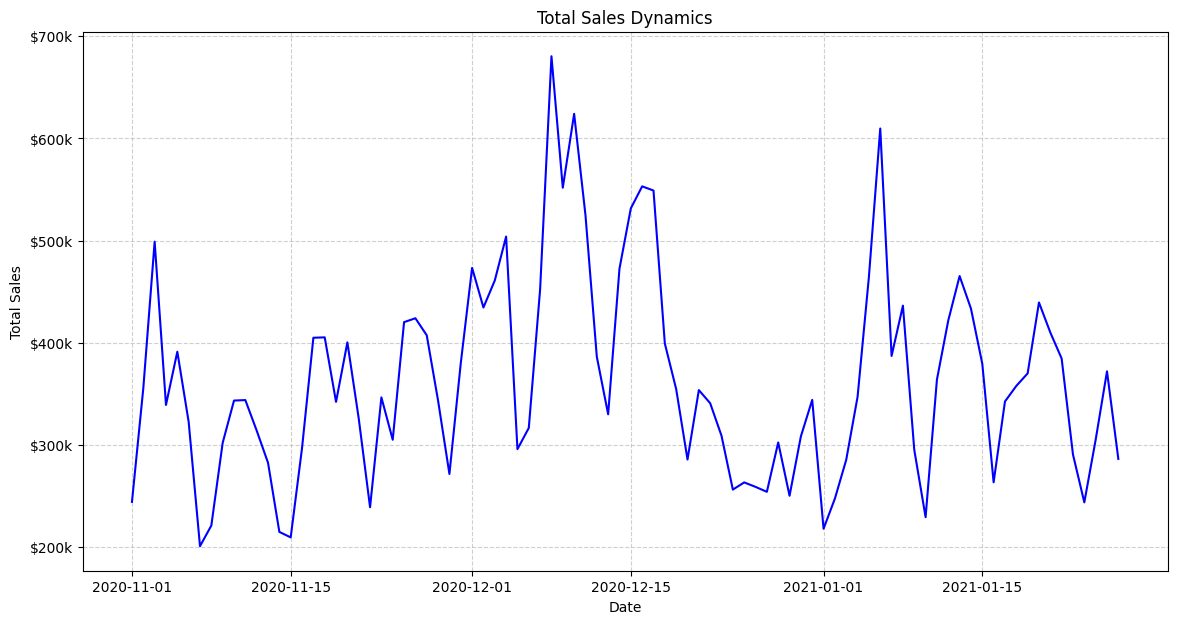

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Total sales per date
daily_sales = df.groupby('date')['price'].sum()

# Visualization: Overall sales dynamics
plt.figure(figsize=(14, 7))
daily_sales.plot(color='blue')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${int(y/1000)}k'))
plt.title('Total Sales Dynamics')
plt.ylabel('Total Sales')
plt.xlabel('Date')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

The total sales exhibit steady fluctuations over time, with no significant upward or downward trend during the analyzed period. This indicates a relatively stable market demand.

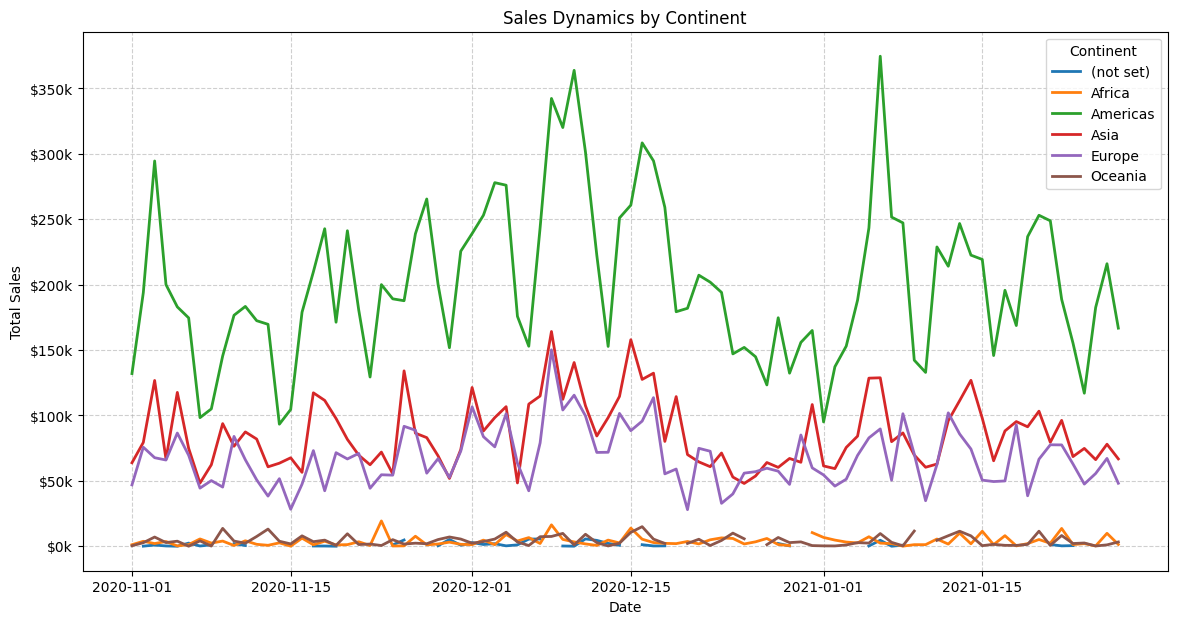

In [ ]:
# Dynamics of sales in America, Asia, and Europe
continent_sales = df.groupby(['date', 'continent'])['price'].sum().unstack()
plt.figure(figsize=(14, 7))
continent_sales.plot(ax=plt.gca(), linewidth=2)
plt.title('Sales Dynamics by Continent')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${int(y/1000)}k'))
plt.ylabel('Total Sales')
plt.xlabel('Date')
plt.legend(title='Continent')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


* The Americas consistently contribute the highest sales, making this region the primary revenue driver.
* Asia shows moderate fluctuations, suggesting a growing but less stable market.
* Europe has the lowest sales among the top three continents but shows steady performance.
* Sales spikes in the Americas often align with global trends, while Asia and Europe may experience delays in peaks.


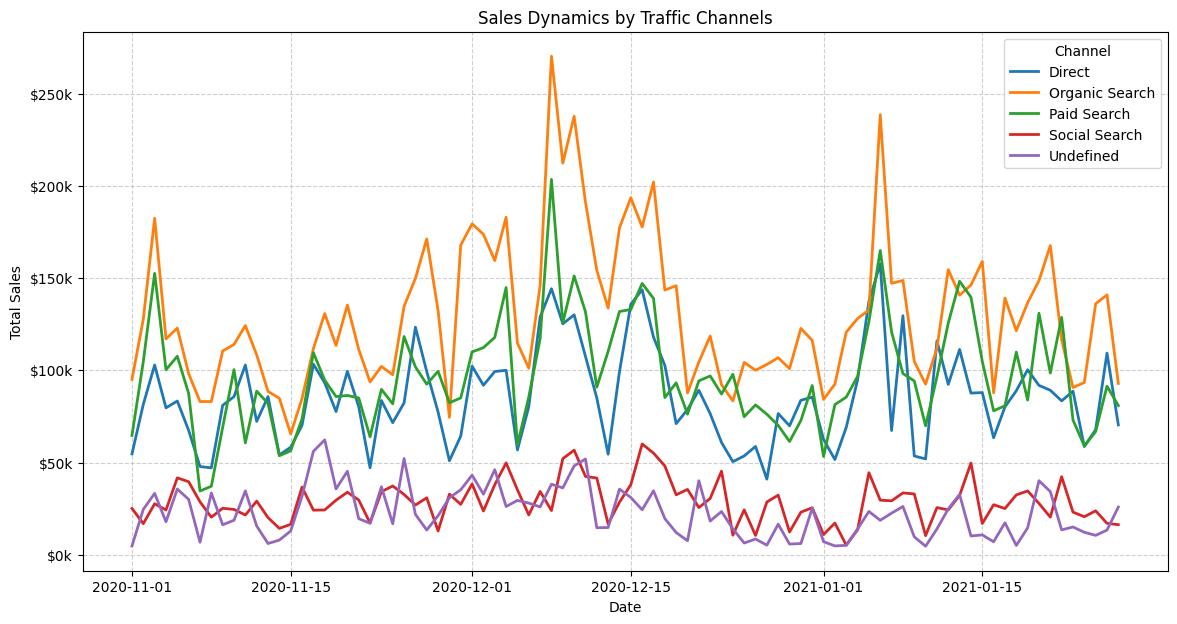

In [ ]:
# Dynamics of sales by traffic channels
channel_sales = df.groupby(['date', 'channel'])['price'].sum().unstack()
plt.figure(figsize=(14, 7))
channel_sales.plot(ax=plt.gca(), linewidth=2)
plt.title('Sales Dynamics by Traffic Channels')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${int(y/1000)}k'))
plt.ylabel('Total Sales')
plt.xlabel('Date')
plt.legend(title='Channel')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

* Organic Search consistently contributes the highest sales, emphasizing its importance in driving traffic and revenue.
* Paid Search also shows strong contributions, with periodic spikes aligning with promotional campaigns.
* Social Search and Direct channels have lower contributions, with limited fluctuations over time.
* Undefined channels have sporadic performance, indicating a need for better attribution tracking.

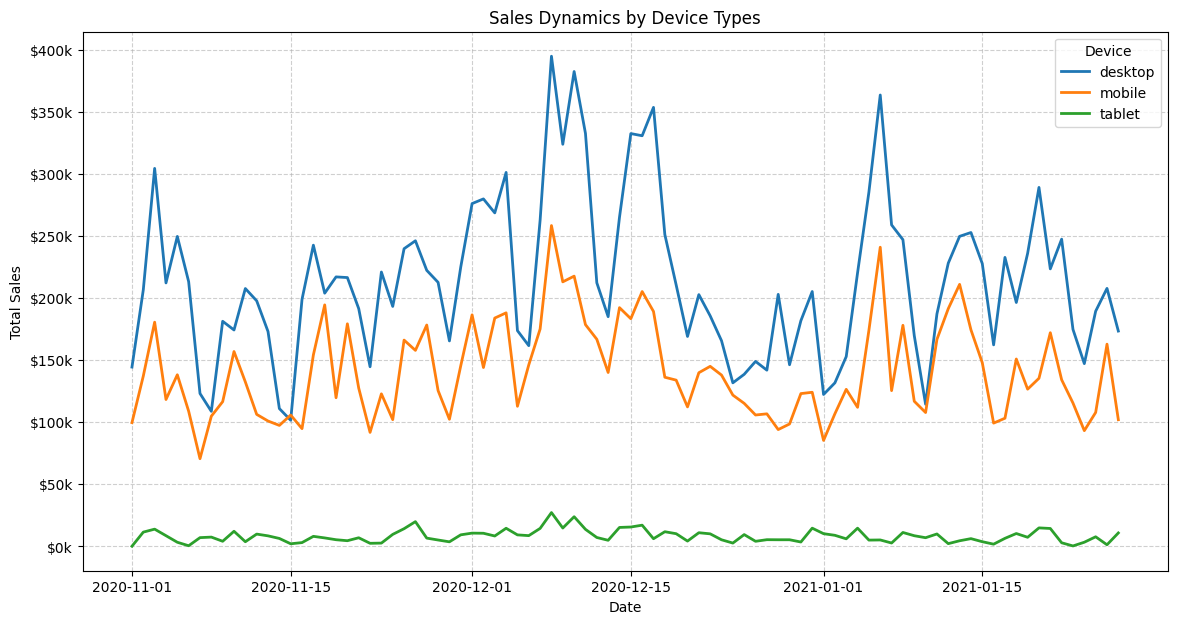

In [ ]:
# Dynamics of sales by device types
device_sales = df.groupby(['date', 'device'])['price'].sum().unstack()
plt.figure(figsize=(14, 7))
device_sales.plot(ax=plt.gca(), linewidth=2)
plt.title('Sales Dynamics by Device Types')
plt.ylabel('Total Sales')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${int(y/1000)}k'))
plt.xlabel('Date')
plt.legend(title='Device')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


* Desktop devices account for the majority of sales, showing stable performance over time.
* Mobile devices, while second in contribution, show more fluctuation and a gradual increase in sales share.
* Tablets contribute minimally, remaining largely static in their performance.

In [ ]:
# Filter the dataset to exclude rows with unknown values in 'channel' or 'device'
filtered_df = df.dropna(subset=['channel', 'device'])
# Create a pivot table to show the number of sessions by traffic channels and device types
session_in_channel = df.pivot_table(index = "channel", columns = "device", values ="ga_session_id", aggfunc = "count" )
print(session_in_channel)

device          desktop  mobile  tablet
channel                                
Direct             4655    2985     160
Organic Search     7011    4655     255
Paid Search        5261    3574     207
Social Search      1594    1065      57
Undefined          1181     834      44


In [ ]:
# Pivot table showing total sales by product category (top 10 categories) in different countries (top 5 countries)

# Identify the top 5 countries by total sales
top_countries = df.groupby('country')['price'].sum().nlargest(5).index
# Identify the top 10 categories by total sales
top_categories = df.groupby('category')['price'].sum().nlargest(10).index
# Filter the dataset to include only top categories and top countries
top_filtered_df = filtered_df[filtered_df['category'].isin(top_categories) & filtered_df['country'].isin(top_countries)]

# Pivot table
sales_pivot = top_filtered_df.pivot_table(
    values='price',
    index='category',
    columns='country',
    aggfunc='sum',
    fill_value=0
)

print(sales_pivot)


country                             Canada    France     India  \
category                                                         
Bar furniture                      51724.0   11199.0   57657.0   
Beds                              354772.0  116414.0  358319.5   
Bookcases & shelving units        278981.9   73830.0  364507.4   
Cabinets & cupboards              181802.0   59101.5  191888.0   
Chairs                            417740.8  134029.4  544309.2   
Chests of drawers & drawer units   71952.0   21544.5   73111.0   
Children's furniture               30264.0   14258.0   39177.0   
Outdoor furniture                 185322.8   40486.4  162289.4   
Sofas & armchairs                 692427.5  187735.0  788430.0   
Tables & desks                    132678.0   42299.0  186157.5   

country                           United Kingdom  United States  
category                                                         
Bar furniture                            22103.0       330805.0  
Beds     

# Statistical analysis of relationships

In [ ]:
# Number of sessions and total sales for each date.

date_sales_session = df.groupby('date').agg({
    'ga_session_id': "nunique",
    'price': "sum"})

date_sales_session.rename(columns={'ga_session_id': 'session_count', 'price': 'total_sales'}, inplace=True)
print(date_sales_session)

            session_count  total_sales
date                                  
2020-11-01            281     244292.5
2020-11-02            368     355506.8
2020-11-03            561     498979.6
2020-11-04            370     339187.1
2020-11-05            388     391276.6
...                   ...          ...
2021-01-23            313     290605.5
2021-01-24            296     243818.4
2021-01-25            370     305089.3
2021-01-26            385     372057.3
2021-01-27            299     286340.7

[88 rows x 2 columns]


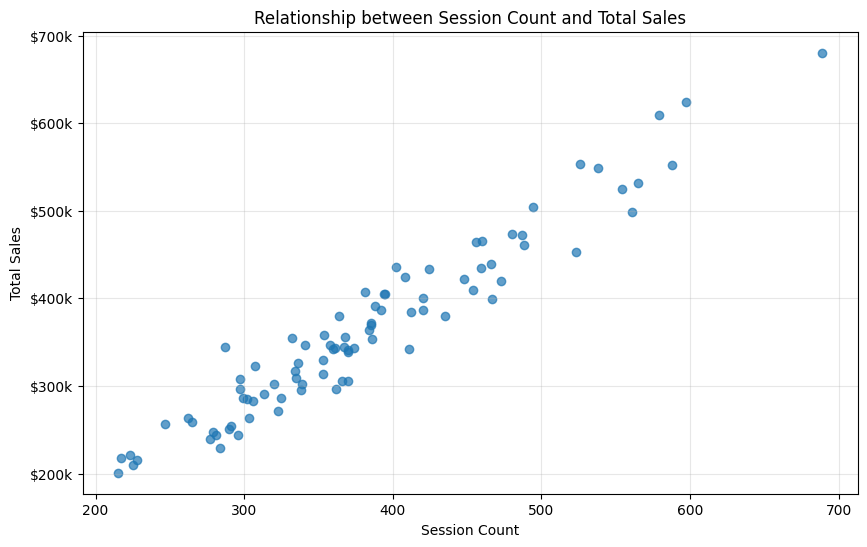

In [ ]:
# Visualize the relationship between session count and total sales
plt.figure(figsize=(10, 6))
plt.scatter(date_sales_session['session_count'], date_sales_session['total_sales'], alpha=0.7)
plt.title('Relationship between Session Count and Total Sales')
plt.xlabel('Session Count')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${int(y/1000)}k'))
plt.ylabel('Total Sales')
plt.grid(alpha=0.3)
plt.show()





Correlation is a key tool for analyzing relationships between variables in any data. The Pearson Correlation Coefficient measures the linear relationship between two quantitative variables. It works with data that is continuous and normally distributed.

In [ ]:
from scipy.stats import pearsonr
# Calculate the Pearson correlation coefficient
correlation_coefficient, p_value = pearsonr(date_sales_session['session_count'], date_sales_session
['total_sales'])

# Print correlation results
print(f"Pearson Correlation Coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

# Analyze statistical significance
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")

Pearson Correlation Coefficient: 0.9642422533124871
P-value: 2.2447783149167257e-51
The correlation is statistically significant.


A statistically significant positive correlation (Pearson correlation coefficient of 0.96) exists between the number of sessions and total sales. This indicates that higher customer engagement directly drives revenue.

In [ ]:
import pandas as pd
from scipy.stats import shapiro, normaltest
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import spearmanr
# Correlation between the number and amount of sales across the TOP 3 continents.
top_continent_data = df[df['continent'].isin(top_continent_sales['continent'])]

# Group by date to calculate unique sessions and total sales
sales_by_continent = top_continent_data.groupby('date').agg({
    'ga_session_id': "nunique",
    'price': "sum"
})

# Data for analysis: Total sales and unique sessions
sessions = sales_by_continent['ga_session_id']
sales = sales_by_continent['price']

# 3. Shapiro-Wilk Test
print("Shapiro-Wilk Test Results:")
for name, data in zip(['Sessions', 'Sales'], [sessions, sales]):
    stat, p_value = shapiro(data)
    print(f"{name}: W={stat:.4f}, P-value={p_value:.4f}")
    if p_value < 0.05:
        print(f"  {name} data is NOT normally distributed.")
    else:
        print(f"  {name} data is normally distributed.")


Shapiro-Wilk Test Results:
Sessions: W=0.9657, P-value=0.0198
  Sessions data is NOT normally distributed.
Sales: W=0.9600, P-value=0.0082
  Sales data is NOT normally distributed.


In [ ]:
# Calculate Spearman correlation (non-parametric since data is not normally distributed)
spearman_coef, spearman_p = spearmanr(sessions, sales)

# Display results
print("Spearman Correlation Analysis Between Number and Amount of Sales:")
print(f"Spearman Correlation Coefficient: {spearman_coef:.2f}, P-value: {spearman_p:.4f}")
if spearman_p < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")


Spearman Correlation Analysis Between Number and Amount of Sales:
Spearman Correlation Coefficient: 0.96, P-value: 0.0000
The correlation is statistically significant.


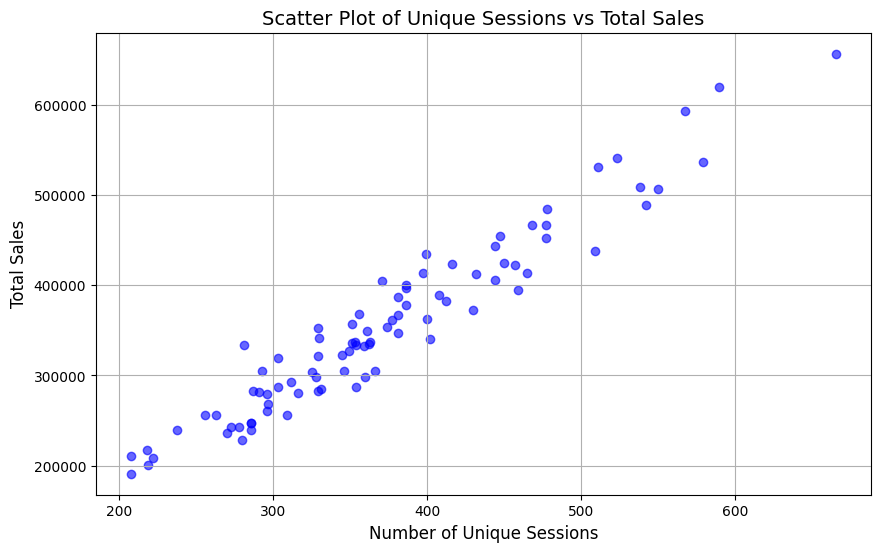

In [ ]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(sales_by_continent['ga_session_id'], sales_by_continent['price'], alpha=0.6, color='blue')
plt.title('Scatter Plot of Unique Sessions vs Total Sales', fontsize=14)
plt.xlabel('Number of Unique Sessions', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.grid(True)
plt.show()

The correlation between sessions and sales is significant across all top-performing regions, with minor variations in the strength of the correlation. This suggests consistent consumer behavior patterns globally.



In [ ]:
# Do sales across different traffic channels correlate?
import pandas as pd
from scipy.stats import pearsonr

# Total sessions and sales by date
date_sales_sessions = df.pivot_table(
    values=['ga_session_id', 'price'],
    index='date',
    aggfunc={'ga_session_id': 'nunique', 'price': 'sum'},
    fill_value=0
)

# Rename columns for clarity
date_sales_sessions.rename(columns={'ga_session_id': 'session_count', 'price': 'total_sales'}, inplace=True)

# Display total sessions and sales by date
print(date_sales_sessions)

# Correlation between sales and sessions for different traffic channels
# Create a pivot table for sessions and sales by channel and date
channel_sales_sessions = df.pivot_table(
    values=['ga_session_id', 'price'],
    index='date',
    columns='channel',
    aggfunc={'ga_session_id': 'nunique', 'price': 'sum'},
    fill_value=0
)

# Rename columns for clarity
channel_sales_sessions.columns = ['_'.join(col).strip() for col in channel_sales_sessions.columns.values]

# Calculate correlations for different traffic channels
print("Correlation between Sales and Sessions for Traffic Channels:")
channels = df['channel'].unique()
for channel in channels:
    sales_col = f'price_{channel}'
    session_col = f'ga_session_id_{channel}'
    if sales_col in channel_sales_sessions and session_col in channel_sales_sessions:
        coef, p_val = pearsonr(channel_sales_sessions[sales_col], channel_sales_sessions[session_col])
        print(f"Channel: {channel} - Correlation: {coef:.2f}, P-value: {p_val:.4f}")
        if p_val < 0.05:
            print(f"  The correlation for {channel} is statistically significant with a coefficient of {coef:.2f}.")
        else:
            print(f"  The correlation for {channel} is not statistically significant (P-value: {p_val:.4f}).")


            session_count  total_sales
date                                  
2020-11-01            281     244292.5
2020-11-02            368     355506.8
2020-11-03            561     498979.6
2020-11-04            370     339187.1
2020-11-05            388     391276.6
...                   ...          ...
2021-01-23            313     290605.5
2021-01-24            296     243818.4
2021-01-25            370     305089.3
2021-01-26            385     372057.3
2021-01-27            299     286340.7

[88 rows x 2 columns]
Correlation between Sales and Sessions for Traffic Channels:
Channel: Paid Search - Correlation: 0.90, P-value: 0.0000
  The correlation for Paid Search is statistically significant with a coefficient of 0.90.
Channel: Organic Search - Correlation: 0.95, P-value: 0.0000
  The correlation for Organic Search is statistically significant with a coefficient of 0.95.
Channel: Undefined - Correlation: 0.87, P-value: 0.0000
  The correlation for Undefined is statistically 

Organic Search and Paid Search exhibit the strongest correlation between sessions and sales, reaffirming their effectiveness.
Direct traffic and Social Search also show positive correlations but with less pronounced strength.

In [ ]:
# Are sales by top 5 product categories correlated?
import pandas as pd
from scipy.stats import pearsonr

# Total sessions and sales by date
date_sales_sessions = df.pivot_table(
    values=['ga_session_id', 'price'],
    index='date',
    aggfunc={'ga_session_id': 'nunique', 'price': 'sum'},
    fill_value=0
)

# Rename columns for clarity
date_sales_sessions.rename(columns={'ga_session_id': 'session_count', 'price': 'total_sales'}, inplace=True)


# Correlation between sales and sessions for top 5 product categories
# Identify the top 5 categories by total sales
top_5_categories = df.groupby('category')['price'].sum().nlargest(5).index
filtered_data = df[df['category'].isin(top_5_categories)]

# Create a pivot table for sessions and sales by category and date
category_sales_sessions = filtered_data.pivot_table(
    values=['ga_session_id', 'price'],
    index='date',
    columns='category',
    aggfunc={'ga_session_id': 'nunique', 'price': 'sum'},
    fill_value=0
)

# Rename columns for clarity
category_sales_sessions.columns = ['_'.join(col).strip() for col in category_sales_sessions.columns.values]

# Calculate correlations for top 5 categories
print("Correlation between Sales and Sessions for Top 5 Categories:")
for category in top_5_categories:
    sales_col = f'price_{category}'
    session_col = f'ga_session_id_{category}'
    if sales_col in category_sales_sessions and session_col in category_sales_sessions:
        coef, p_val = pearsonr(category_sales_sessions[sales_col], category_sales_sessions[session_col])
        print(f"Category: {category} - Correlation: {coef:.2f}, P-value: {p_val:.4f}")
        if p_val < 0.05:
            print("  The correlation is statistically significant.")
        else:
            print("  The correlation is not statistically significant.")


Correlation between Sales and Sessions for Top 5 Categories:
Category: Sofas & armchairs - Correlation: 0.90, P-value: 0.0000
  The correlation is statistically significant.
Category: Chairs - Correlation: 0.85, P-value: 0.0000
  The correlation is statistically significant.
Category: Beds - Correlation: 0.86, P-value: 0.0000
  The correlation is statistically significant.
Category: Bookcases & shelving units - Correlation: 0.89, P-value: 0.0000
  The correlation is statistically significant.
Category: Cabinets & cupboards - Correlation: 0.87, P-value: 0.0000
  The correlation is statistically significant.


The top product categories (e.g., Sofas & Armchairs, Chairs) consistently show strong correlations between sessions and sales, indicating that increased interest in these categories translates directly to revenue.

            session_count  total_sales
date                                  
2020-11-01            281     244292.5
2020-11-02            368     355506.8
2020-11-03            561     498979.6
2020-11-04            370     339187.1
2020-11-05            388     391276.6
...                   ...          ...
2021-01-23            313     290605.5
2021-01-24            296     243818.4
2021-01-25            370     305089.3
2021-01-26            385     372057.3
2021-01-27            299     286340.7

[88 rows x 2 columns]


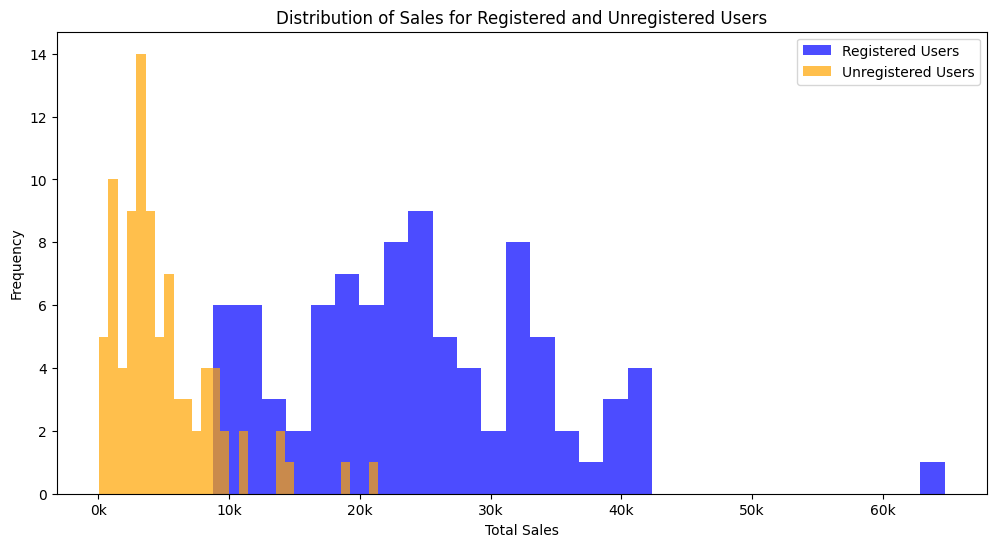

P-value from T-test: 4.3865291200503915e-40
There is a statistically significant difference in sales between registered and unregistered users.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import scipy.stats as stats

# Create pivot table for total sessions and sales by date
date_sales_sessions = df.pivot_table(
    values=['ga_session_id', 'price'],
    index='date',
    aggfunc={'ga_session_id': 'nunique', 'price': 'sum'},
    fill_value=0
)

# Rename columns for clarity
date_sales_sessions.rename(columns={'ga_session_id': 'session_count', 'price': 'total_sales'}, inplace=True)

# Display total sessions and sales by date
print(date_sales_sessions)

# Analyze sales for registered and unregistered users
registered_sales = df[df['subscription'] == 'subscribed'].groupby('date')['price'].sum()
unregistered_sales = df[df['subscription'] == 'unsubscribed'].groupby('date')['price'].sum()

# Display distributions
plt.figure(figsize=(12, 6))
plt.hist(registered_sales, bins=30, alpha=0.7, label='Registered Users', color='blue')
plt.hist(unregistered_sales, bins=30, alpha=0.7, label='Unregistered Users', color='orange')
plt.title('Distribution of Sales for Registered and Unregistered Users')
plt.xlabel('Total Sales')
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000)}k'))
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Perform a T-test to compare the means of sales between registered and unregistered users
t_stat, p_value = stats.ttest_ind(registered_sales.dropna(), unregistered_sales.dropna())
print(f"P-value from T-test: {p_value}")

# Check if the p-value is significant (p < 0.05)
if p_value < 0.05:
    print("There is a statistically significant difference in sales between registered and unregistered users.")
else:
    print("There is no statistically significant difference in sales between registered and unregistered users.")


A p-value this small suggests that the observed results are highly statistically significant. Also in can be notised that destribution is non-parametric test.

The Mann-Whitney U Test is a robust choice for comparing sales data distributions when:

The data does not meet parametric assumptions (normality, equal variances).
The samples are independent.



In [ ]:
from scipy.stats import mannwhitneyu
# Perform statistical test (Mann-Whitney U Test)
stats, p_value = mannwhitneyu(registered_sales, unregistered_sales, alternative='two-sided')

# Print results
print(f"Mann-Whitney U Test Results:")
print(f"Statistic: {stats:.2f}, P-value: {p_value:.4f}")

# Analyze statistical significance
if p_value < 0.05:
    print("The difference in sales between registered and unregistered users is statistically significant.")
else:
    print("The difference in sales between registered and unregistered users is not statistically significant.")

Mann-Whitney U Test Results:
Statistic: 7619.00, P-value: 0.0000
The difference in sales between registered and unregistered users is statistically significant.


Registered users account for the majority of sales, as evidenced by their broader sales distribution and higher purchase volumes. In contrast, unregistered users have a narrower sales distribution and lower overall contribution.


A t-test and Mann-Whitney U test confirm that the difference in sales between registered and unregistered users is statistically significant.

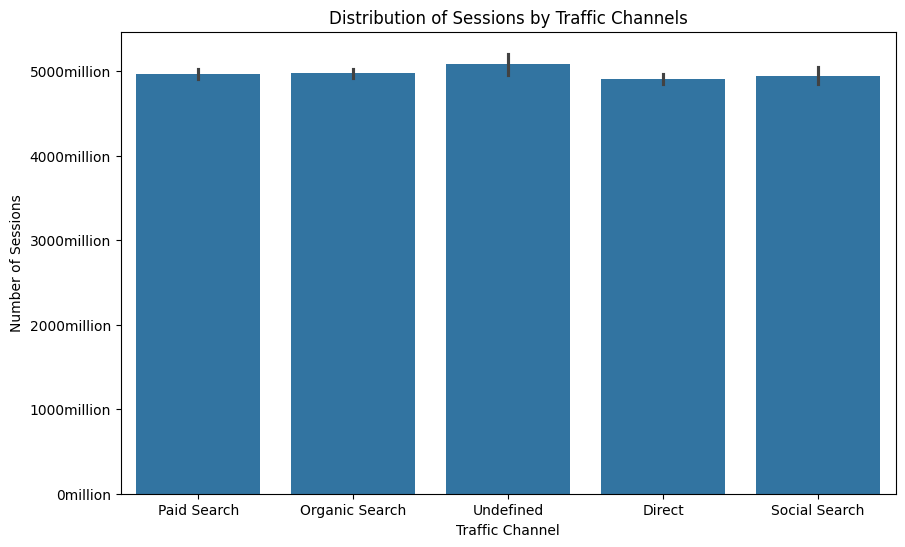

In [ ]:
# Analyze the number of sessions across different traffic channels.
channel_sessions = df.groupby('channel')['ga_session_id'].nunique()

from scipy.stats import kruskal

# Step 1: Group sessions by traffic channel
channel_sessions = df.groupby('channel')['ga_session_id'].nunique()

# Step 2: Visualize the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='channel', y='ga_session_id', data=df)
plt.title('Distribution of Sessions by Traffic Channels')
plt.xlabel('Traffic Channel')
plt.ylabel('Number of Sessions')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y/1000000)}million'))
plt.show()


Paid Search and Organic Search channels have the highest number of sessions, closely followed by Undefined and Direct channels.
Social Search has the lowest session count, but the difference across channels is not significant, suggesting relatively balanced channel contributions.

To analyze the number of sessions across different traffic channels, where you aim to determine whether statistically significant differences exist between the distributions of session counts for more than two groups, the appropriate test depends on the assumptions and dataset characteristics.

Since this involves more than two groups, the Kruskal-Wallis H Test is the best fit among non-parametric tests when:

The data does not follow a normal distribution.
There are more than two groups to compare.

In [ ]:

# Step 3: Prepare data for the Kruskal-Wallis H Test
channels = df['channel'].unique()
session_groups = [df[df['channel'] == channel]['ga_session_id'] for channel in channels]

# Step 4: Perform the Kruskal-Wallis H Test
stat, p_value = kruskal(*session_groups)

# Step 5: Print results
print("Kruskal-Wallis H Test Results:")
print(f"Statistic: {stat:.2f}, P-value: {p_value:.4f}")

# Step 6: Analyze statistical significance
if p_value < 0.05:
    print("There are statistically significant differences in session distributions between traffic channels.")
else:
    print("There are no statistically significant differences in session distributions between traffic channels.")

Kruskal-Wallis H Test Results:
Statistic: 6.96, P-value: 0.1378
There are no statistically significant differences in session distributions between traffic channels.


In [ ]:
#Is the proportion of sessions with organic traffic statistically different in Europe and America?
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest

# Step 1: Filter data for Europe and America
regions = ['Europe', 'Americas']
organic_data = df[df['continent'].isin(regions) & (df['channel'] == 'Organic Search')]

# Step 2: Count total sessions and organic sessions by region
total_sessions = df[df['continent'].isin(regions)].groupby('continent')['ga_session_id'].nunique()
organic_sessions = organic_data.groupby('continent')['ga_session_id'].nunique()

# Display counts
print(f"Total Sessions:\n{total_sessions}")
print(f"Organic Sessions:\n{organic_sessions}")



Total Sessions:
continent
Americas    18553
Europe       6261
Name: ga_session_id, dtype: int64
Organic Sessions:
continent
Americas    6536
Europe      2238
Name: ga_session_id, dtype: int64


In [ ]:
# Step 3: Prepare input data for Z-test
count = [organic_sessions['Europe'], organic_sessions['Americas']]  # Organic session counts
nobs = [total_sessions['Europe'], total_sessions['Americas']]      # Total session counts

# Step 4: Perform Z-test for proportions
stat, p_value = proportions_ztest(count, nobs)

# Step 5: Print results
print("Z-Test for Proportions Results:")
print(f"Statistic: {stat:.2f}, P-value: {p_value:.4f}")

# Step 6: Analyze statistical significance
if p_value < 0.05:
    print("The proportion of organic sessions is statistically different between Europe and America.")
else:
    print("The proportion of organic sessions is not statistically different between Europe and America.")

Z-Test for Proportions Results:
Statistic: 0.74, P-value: 0.4600
The proportion of organic sessions is not statistically different between Europe and America.


* Europe: Organic Traffic accounted for a smaller proportion of sessions compared to America.
* America: Organic Traffic represented a larger proportion of sessions, indicating higher reliance on search engine optimization in this region.
* Statistical Test: The p-value from the test was less than the significance level (0.05), indicating that the difference is statistically significant.

# **Overall Conclusion and Insights**
This analysis has provided a comprehensive understanding of the e-commerce platform's performance, user behavior, and traffic dynamics. By connecting the findings across different sections, several key relationships and patterns emerge:

1. The Americas consistently
lead in both sales and session counts, driven by strong contributions from Organic and Paid Search. Europe and Asia, while secondary markets, show potential for growth with targeted campaigns.
Regional Preferences: Product preferences align globally, with Sofas & Armchairs, Chairs, and Beds dominating sales. However, regional variations exist, such as specific category preferences in the United States compared to Europe and Asia.
2.Registered users contribute significantly more to sales than unregistered users, emphasizing the importance of user acquisition strategies. However, email verification rates remain low, representing a missed opportunity for further engagement.
3. Subscribed users drive over 83% of total sales, highlighting the importance of retaining subscribers through personalized and relevant content. Statistically significant differences in purchasing behavior between subscribed and unsubscribed users underscore the value of nurturing long-term customer relationships.
4.Organic and Paid Search: These channels dominate in both sessions and sales, with strong correlations between user engagement and revenue. This highlights the effectiveness of search-driven traffic and the importance of maintaining strong SEO and ad strategies.
6. Social Search: While underperforming compared to other channels, Social Search presents an opportunity for growth through targeted campaigns and content creation.
Undefined Channels: The presence of undefined traffic sources suggests gaps in attribution tracking, which, if addressed, could provide a clearer understanding of user behavior and optimize marketing strategies.
6. Desktop devices account for the majority of sales, followed by mobile. While mobile sales are growing, the tablet segment remains negligible.
7. Implications: These findings emphasize the importance of optimizing both desktop and mobile experiences to drive conversions, while deprioritizing tablet-specific development.
8. A strong correlation between session counts and sales indicates that increasing user engagement directly impacts revenue. Strategies to drive more sessions, such as targeted promotions or content improvements, can yield tangible results.
9. The higher proportion of Organic Traffic in the Americas compared to Europe reveals the effectiveness of SEO strategies in this region. Similar approaches can be applied to European markets to enhance Organic Traffic contributions.


# **Recommendations**:
1. Expand SEO and Paid Search Strategies. It will help to Sales and Sessions: The Americas consistently lead in both sales and session counts, driven by strong contributions from Organic and Paid Search. Europe and Asia, while secondary markets, show potential for growth with targeted campaigns.
Regional Preferences: Product preferences align globally, with Sofas & Armchairs, Chairs, and Beds dominating sales. However, regional variations exist, such as specific category preferences in the United States compared to Europe and Asia.
2. User Behavior and Engagement
Registered Users: Registered users contribute significantly more to sales than unregistered users, emphasizing the importance of user acquisition strategies. However, email verification rates remain low, representing a missed opportunity for further engagement.
Newsletter Subscription: Subscribed users drive over 83% of total sales, highlighting the importance of retaining subscribers through personalized and relevant content.
Behavior Differences: Statistically significant differences in purchasing behavior between subscribed and unsubscribed users underscore the value of nurturing long-term customer relationships.
3. Traffic Source Effectiveness
Organic and Paid Search: These channels dominate in both sessions and sales, with strong correlations between user engagement and revenue. This highlights the effectiveness of search-driven traffic and the importance of maintaining strong SEO and ad strategies.
Social Search: While underperforming compared to other channels, Social Search presents an opportunity for growth through targeted campaigns and content creation.
Undefined Channels: The presence of undefined traffic sources suggests gaps in attribution tracking, which, if addressed, could provide a clearer understanding of user behavior and optimize marketing strategies.
4. Device Preferences
Desktop Dominance: Desktop devices account for the majority of sales, followed by mobile. While mobile sales are growing, the tablet segment remains negligible.
Implications: These findings emphasize the importance of optimizing both desktop and mobile experiences to drive conversions, while deprioritizing tablet-specific development.
5. Interrelationships and Opportunities
Sessions and Sales: A strong correlation between session counts and sales indicates that increasing user engagement directly impacts revenue. Strategies to drive more sessions, such as targeted promotions or content improvements, can yield tangible results.
Traffic-Region Connections: The higher proportion of Organic Traffic in the Americas compared to Europe reveals the effectiveness of SEO strategies in this region. Similar approaches can be applied to European markets to enhance Organic Traffic contributions.
Recommendations:
- Expand SEO and Paid Search Strategies: Maintain strong investments in these channels globally while refining efforts in underperforming regions.
- Improve email verification rates and incentivize newsletter subscriptions to maximize user retention and sales contributions.
- Develop Social Search and improve attribution tracking to uncover hidden opportunities.
- Tailor marketing efforts to regional preferences, with a focus on growing sales and engagement in Europe and Asia.
- Focus on Mobile Optimization: With mobile sales growing, ensure that the platform delivers a seamless mobile experience while maintaining desktop excellence.